In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

from keras.utils.np_utils import to_categorical
from glob import glob
from sklearn.datasets import load_files

Using TensorFlow backend.


In [6]:
def load(path):
    data= load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']),133)
    return dog_files,dog_targets

train_files,train_targets=load('F:/dog-project-master/dogImages/dogImages/train')
test_files,test_targets=load('F:/dog-project-master/dogImages/dogImages/test')
valid_files, valid_targets = load('F:/dog-project-master/dogImages/dogImages/valid')

dog_names = [item[20:-1] for item in sorted(glob("F:/dog-project-master/dogImages/dogImages/train/*/"))]

print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [7]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x=image.img_to_array(img)
    
    return np.expand_dims(x,axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors= [path_to_tensor(img_path) for img_path in tqdm(img_paths)] 
    return np.vstack(list_of_tensors)


In [8]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:19<00:00, 43.56it/s]


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512,(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(133,activation='softmax')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [10]:
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [11]:
model.fit(train_tensors,train_targets,validation_data= (valid_tensors,valid_targets),epochs=10,batch_size=16,verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 - 51s - loss: 4.8891 - acc: 0.0082 - val_loss: 4.8706 - val_acc: 0.0108
Epoch 2/10
6680/6680 - 26s - loss: 4.8047 - acc: 0.0175 - val_loss: 4.7506 - val_acc: 0.0180
Epoch 3/10
6680/6680 - 26s - loss: 4.6464 - acc: 0.0205 - val_loss: 4.5272 - val_acc: 0.0335
Epoch 4/10
6680/6680 - 24s - loss: 4.4813 - acc: 0.0326 - val_loss: 4.5549 - val_acc: 0.0359
Epoch 5/10
6680/6680 - 24s - loss: 4.2897 - acc: 0.0496 - val_loss: 4.5097 - val_acc: 0.0335
Epoch 6/10
6680/6680 - 24s - loss: 4.1133 - acc: 0.0663 - val_loss: 4.0389 - val_acc: 0.0647
Epoch 7/10
6680/6680 - 23s - loss: 3.9534 - acc: 0.0792 - val_loss: 4.4010 - val_acc: 0.0551
Epoch 8/10
6680/6680 - 23s - loss: 3.8468 - acc: 0.0963 - val_loss: 4.1136 - val_acc: 0.0623
Epoch 9/10
6680/6680 - 22s - loss: 3.7087 - acc: 0.1067 - val_loss: 3.8766 - val_acc: 0.0910
Epoch 10/10
6680/6680 - 26s - loss: 3.5988 - acc: 0.1263 - val_loss: 3.7494 - val_acc: 0.0946


In [12]:
dog_breed_predictions =[np.argmax(model.predict(np.expand_dims(tensor,axis=0))) for tensor in test_tensors]
test_acc= 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets,axis=1))/len(dog_breed_predictions)

In [13]:
print('Test accuracy: %.4f%%' % test_acc)

Test accuracy: 11.9617%


In [14]:
features = np.load('F:/dog-project-master/DogXceptionData.npz')
train_Xception = features['train']
valid_Xception = features['valid']
test_Xception = features['test']

In [15]:
Xception_model = tf.keras.models.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(133,activation='softmax')
])


In [16]:
Xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               136325    
Total params: 1,710,725
Trainable params: 1,710,725
Non-trainable params: 0
____________________________________________

In [17]:
Xception_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['acc'])

In [9]:

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=100, batch_size=20, verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - ETA: 31:39 - loss: 4.9482 - acc: 0.05 - ETA: 6:19 - loss: 4.8961 - acc: 0.0500 - ETA: 3:57 - loss: 4.9089 - acc: 0.037 - ETA: 2:52 - loss: 4.8771 - acc: 0.045 - ETA: 2:06 - loss: 4.8407 - acc: 0.060 - ETA: 1:39 - loss: 4.8186 - acc: 0.063 - ETA: 1:21 - loss: 4.8082 - acc: 0.067 - ETA: 1:09 - loss: 4.7966 - acc: 0.063 - ETA: 1:00 - loss: 4.7763 - acc: 0.067 - ETA: 53s - loss: 4.7489 - acc: 0.077 - ETA: 48s - loss: 4.7308 - acc: 0.08 - ETA: 43s - loss: 4.7102 - acc: 0.08 - ETA: 39s - loss: 4.6938 - acc: 0.09 - ETA: 36s - loss: 4.6820 - acc: 0.09 - ETA: 33s - loss: 4.6670 - acc: 0.10 - ETA: 31s - loss: 4.6410 - acc: 0.11 - ETA: 28s - loss: 4.6196 - acc: 0.12 - ETA: 26s - loss: 4.5926 - acc: 0.14 - ETA: 25s - loss: 4.5737 - acc: 0.15 - ETA: 23s - loss: 4.5539 - acc: 0.15 - ETA: 22s - loss: 4.5296 - acc: 0.16 - ETA: 21s - loss: 4.5066 - acc: 0.17 - ETA: 19s - loss: 4.4827 - acc: 0.17 - ET

In [10]:
Xception_model.save_weights('weights.best.Xception.hdf5')


In [11]:
Xception_model.load_weights('weights.best.Xception.hdf5')


In [12]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 86.1244%


In [13]:
def extract_Xception(tensor):
    from tensorflow.python.keras.applications.xception import Xception, preprocess_input
    return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def Xception_predict_breed(img_path):
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))     
    predicted_vector = Xception_model.predict(bottleneck_feature)       
    return dog_names[np.argmax(predicted_vector)]                       

In [33]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def my_predictor(img_path):
    img= mpimg.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    
    print("It is a dog!.Dog breed is: \n",Xception_predict_breed(img_path)[32:])
  

It is a dog!.Dog breed is: 
 Curly-coated_retriever


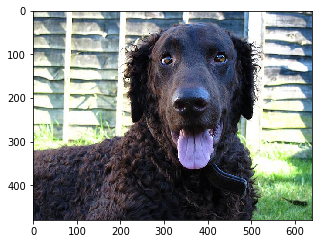

In [34]:
my_predictor('images/Curly-coated_retriever_03896.jpg')

It is a dog!.Dog breed is: 
 Havanese


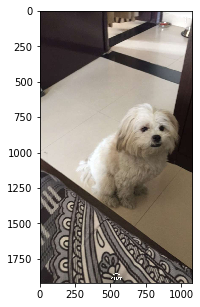

In [35]:
my_predictor('images/abc.jpg')

It is a dog!.Dog breed is: 
 Labrador_retriever


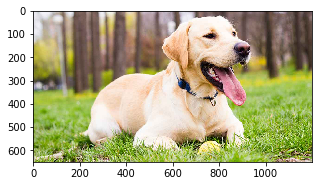

In [40]:
my_predictor('images/dba.jpg')